# Intent de detecció de tapes de clavagueres

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#%matplotlib notebook

Carreguem el vídeo i n'extreiem alguns frames. Això està fet agafant el vídeo, s'haria de mirar com fer-ho per obrir l'stream de càmera.

In [3]:
def extract_mages_every_n_secs(video_path, image_path, n):
    count = 0
    vidcap = cv.VideoCapture(video_path)
    success,image = vidcap.read()

    while success:
        vidcap.set(cv.CAP_PROP_POS_MSEC,(count*1000)) 
        success,image = vidcap.read()
        print ('Read frame ', count)
        cv.imwrite(image_path + "frame%d.jpg" % count, image)
        count = count + n

In [4]:
extract_mages_every_n_secs('./debrecen.mov', './images_full/', 1)

('Read frame ', 0)
('Read frame ', 1)
('Read frame ', 2)
('Read frame ', 3)
('Read frame ', 4)
('Read frame ', 5)
('Read frame ', 6)
('Read frame ', 7)
('Read frame ', 8)
('Read frame ', 9)
('Read frame ', 10)
('Read frame ', 11)
('Read frame ', 12)
('Read frame ', 13)
('Read frame ', 14)
('Read frame ', 15)
('Read frame ', 16)
('Read frame ', 17)
('Read frame ', 18)
('Read frame ', 19)
('Read frame ', 20)
('Read frame ', 21)
('Read frame ', 22)
('Read frame ', 23)
('Read frame ', 24)
('Read frame ', 25)
('Read frame ', 26)
('Read frame ', 27)
('Read frame ', 28)
('Read frame ', 29)
('Read frame ', 30)
('Read frame ', 31)
('Read frame ', 32)
('Read frame ', 33)
('Read frame ', 34)
('Read frame ', 35)
('Read frame ', 36)
('Read frame ', 37)
('Read frame ', 38)
('Read frame ', 39)
('Read frame ', 40)
('Read frame ', 41)
('Read frame ', 42)
('Read frame ', 43)
('Read frame ', 44)
('Read frame ', 45)
('Read frame ', 46)
('Read frame ', 47)
('Read frame ', 48)
('Read frame ', 49)
('Read fra

KeyboardInterrupt: 

In [19]:
im = cv.imread("images_full/frame6.jpg")
im.shape

(1080, 1920, 3)

In [20]:
height, width = im.shape[:2]

# K is the camera parameters matrix. We dont have them so we just take a sensible ones.
K = np.eye(3)
K[0,0] = K[1,1] = 1000
K[0:2, 2] = (width-1)/2.0, (height-1)/2.0

# Distortion coeffitients, same as above
distorsion_coefs = np.float32([-0.54,  0.28, 0., 0., 0.])

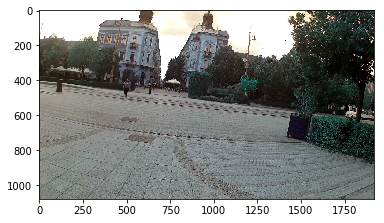

In [21]:
#plt.figure(figsize=(10.00, 6))
plt.imshow(im)

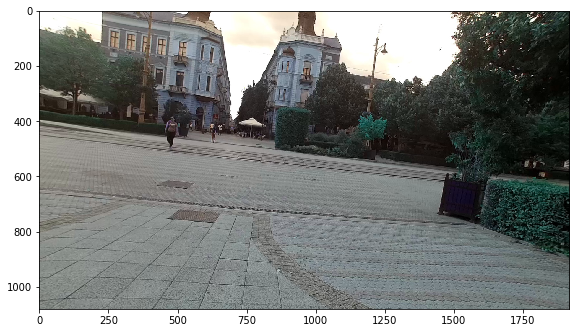

In [22]:
undistorted_im = cv.undistort(im, K, np.float32([-0.2,  0., 0., 0., 0.])) #-0.2 a full, -0.7 half

plt.figure(figsize=(9.5, 6))
plt.imshow(undistorted_im)

In [9]:
#Tot això no funciona gaire bé, la calculada a mà és molt millor!

model_pts = np.float32([
    [0,  1080],
    [1920, 1080],
    [0,  0.],
    [1920, 0]])


sqr_size = 150


tl_x = 1000
tl_y = 1000
tr_x = tl_x + sqr_size
tr_y = tl_y
bl_x = tl_x
bl_y = tl_x + sqr_size
br_x = bl_x + sqr_size
br_y = bl_y




model_pts = np.float32([
    [bl_x, bl_y],
    [br_x, br_y],
    [tl_x, tl_y],
    [tr_x, tr_y]
])


impts_undist = np.float32([
    [ 0, 770],
    [ 770, 800],
    [ 686, 536],
    [ 800, 546]])

impts_undist = np.float32([
    [ 29, 973],
    [ 483, 970],
    [ 278, 832],
    [ 571, 861]])

H = cv.getPerspectiveTransform(impts_undist, model_pts) 

In [10]:
# Calculem-la a mà, a veure si millora...

H = np.float32([[-1.11820478e+00, -1.44434783e+00,  1.22173190e+03],
 [ 1.15380049e+00, -1.00482878e+01,  4.57791522e+03],
 [ 5.96037882e-04, -3.75442027e-03,  1.00000000e+00]])



In [23]:
topdown = cv.warpPerspective(undistorted_im, H, dsize=(3000, 2200))

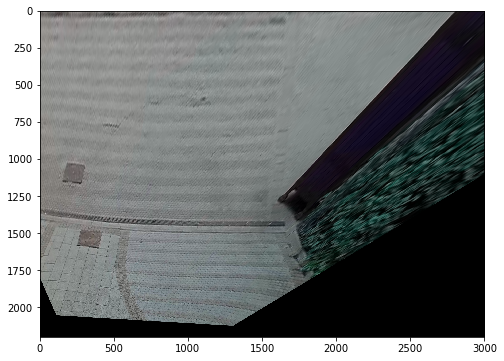

In [24]:
plt.figure(figsize=(9.5, 6))
plt.imshow(topdown)

In [13]:
#I si volem recuperar la posició de qualsevol cosa, fem la inversa:

H_inv = homography_inverse = np.linalg.inv(H)
back = cv.warpPerspective(topdown, H_inv, dsize=(1920, 1080)) #Això torna a ser el retall de la original.
#plt.imshow(back)

### Detecció de clavagueres

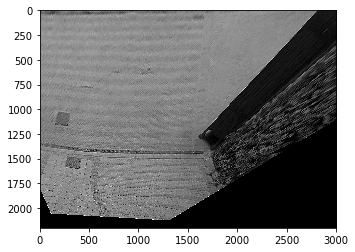

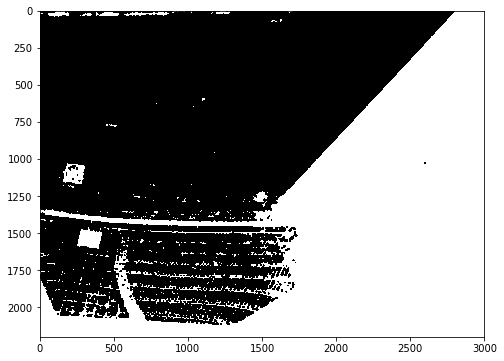

In [25]:
gray = cv.cvtColor(topdown, cv.COLOR_BGR2GRAY)
blur = cv.medianBlur(gray, 5)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv.filter2D(blur, -1, sharpen_kernel)

plt.imshow(sharpen, cmap='gray')

_, thresh = cv.threshold(sharpen, 95, 255, cv.THRESH_BINARY_INV)
kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
#close = cv.morphologyEx(thresh, cv.MORPH_DILATE, kernel, iterations=2)
close = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=5)
close = cv.medianBlur(close, 7)


plt.figure(figsize=(9.5, 6))
plt.imshow(close, cmap='gray')

In [26]:
def areaFilter(minArea, inputImage):

    # Perform an area filter on the binary blobs:
    componentsNumber, labeledImage, componentStats, componentCentroids = \
    cv.connectedComponentsWithStats(inputImage, connectivity=4)

    # Get the indices/labels of the remaining components based on the area stat
    # (skip the background component at index 0)
    remainingComponentLabels = [i for i in range(1, componentsNumber) if componentStats[i][4] >= minArea]

    # Filter the labeled pixels based on the remaining labels,
    # assign pixel intensity to 255 (uint8) for the remaining pixels
    filteredImage = np.where(np.isin(labeledImage, remainingComponentLabels) == True, 255, 0).astype('uint8')

    return filteredImage

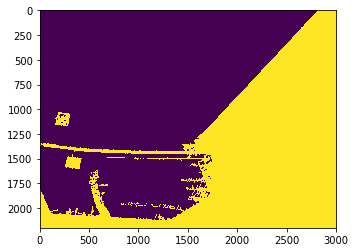

In [27]:
minArea = 5000 #Inicialment era 12000
close_filt = areaFilter(minArea, close)
plt.imshow(close_filt)
#th2 = cv.adaptiveThreshold(sharpen,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)
#plt.imshow(sharpen, cmap='gray')

In [82]:
"""
topdown_bw = cv.cvtColor(topdown, cv.COLOR_BGR2GRAY)
thresh, topdown_th = cv.threshold(topdown_bw, 120, 255, cv.THRESH_BINARY)

kernel = np.ones((5,5),np.float32)/25

mask = cv.inRange(dst, 5, 120)

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (9,9))
clean = cv.morphologyEx(mask, cv.MORPH_OPEN, mask)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (15,15))
clean = cv.morphologyEx(mask, cv.MORPH_CLOSE, mask)
#dst = cv.filter2D(topdown_bw,-1,kernel)




plt.figure(figsize=(9.5, 6))
plt.imshow(clean)
""""""

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-82-c4a21441ef66>, line 20)

In [45]:
"""
contours, _ = cv.findContours(close_filt, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
print(len(contours))
for contour in contours:
    shape = cv.approxPolyDP(contour, 0.01*cv.arcLength(contour, True), True)
    x_cor = shape.ravel()[0]
    y_cor = shape.ravel()[1]
    
    if len(shape) ==4:
        #shape cordinates
        x,y,w,h = cv.boundingRect(shape)

        #width:height
        aspectRatio = float(w)/h
        cv.drawContours(topdown, [shape], 0, (0,255,0), 4)
        if aspectRatio >= 0.9 and aspectRatio <=1.1:
            cv.putText(topdown, "Square", (x_cor, y_cor), cv.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0))
        else:
            cv.putText(topdown, "Rectangle", (x_cor, y_cor), cv.FONT_HERSHEY_COMPLEX, 0.5, (255,0,0))
        
#cv.imshow("Shape", topdown)
"""

'\ncontours, _ = cv.findContours(close_filt, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)\nprint(len(contours))\nfor contour in contours:\n    shape = cv.approxPolyDP(contour, 0.01*cv.arcLength(contour, True), True)\n    x_cor = shape.ravel()[0]\n    y_cor = shape.ravel()[1]\n    \n    if len(shape) ==4:\n        #shape cordinates\n        x,y,w,h = cv.boundingRect(shape)\n\n        #width:height\n        aspectRatio = float(w)/h\n        cv.drawContours(topdown, [shape], 0, (0,255,0), 4)\n        if aspectRatio >= 0.9 and aspectRatio <=1.1:\n            cv.putText(topdown, "Square", (x_cor, y_cor), cv.FONT_HERSHEY_COMPLEX, 0.5, (0,0,0))\n        else:\n            cv.putText(topdown, "Rectangle", (x_cor, y_cor), cv.FONT_HERSHEY_COMPLEX, 0.5, (255,0,0))\n        \n#cv.imshow("Shape", topdown)\n'

3
(248, 1458, 173, 151, 16552.0, 1.1456953642384107)
(151, 1030, 154, 144, 16207.5, 1.0694444444444444)
(0, 0, 3000, 2200, 2649383.5, 1.3636363636363635)


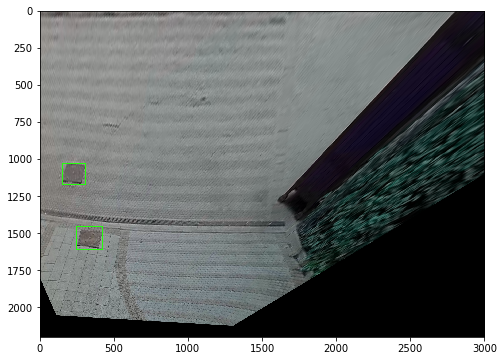

In [29]:
cnts = cv.findContours(close_filt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

print(len(cnts))

min_area = 12000
max_area = 100000
image_number = 0
for c in cnts:
    area = cv.contourArea(c)
    x,y,w,h = cv.boundingRect(c)
    aspect_ratio = float(w)/h
    print(x,y,w,h, area, aspect_ratio)
    #if area > min_area and area < max_area:
    if aspect_ratio > 0.8 and aspect_ratio < 1.5 and area < max_area:
        ROI = topdown[y:y+h, x:x+w]
        cv.rectangle(topdown, (x, y), (x + w, y + h), (36,255,12), 5)
        image_number += 1

plt.figure(figsize=(9.5, 6))
plt.imshow(topdown)

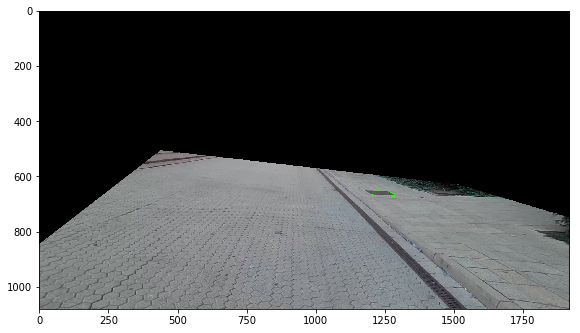

In [18]:
back = cv.warpPerspective(topdown, H_inv, dsize=(1920, 1080))
plt.figure(figsize=(9.5, 6))
plt.imshow(back)